# 第三章 稠密检索 Dense Retrieval
  本节课将分为两部分。第一部分中，我们将使用第 1 节用到的数据库，并用第 2 节中学到的 embeddings 应用于语义检索。

  第二部分中，我们将从头开始对文本进行处理，看如何构建一个全新的向量索引。

## 一、安装 Setup
安装必须的 Python 库并且准备好后续内容所需要的 api-keys

* 安装 Cohere 获取 embedding
* 使用 Annoy 进行近似最近邻搜索
* dotenv 库是用来检查环境变量的~
* 'CO_API_KEY' 需要自己注册获取，网址：https://dashboard.cohere.com/api-keys

In [12]:
# !pip install cohere 
# !pip install weaviate-client 
# !pip install python-dotenv
# !pip install Annoy

In [6]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # 读取本地的 .env 文件

In [7]:
import cohere
co = cohere.Client(os.environ['CO_API_KEY'])#获取 cohere 服务

In [13]:
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key=os.environ['WEAVIATE_API_KEY'])

In [14]:
client = weaviate.Client(
    url=os.environ['WEAVIATE_API_URL'],
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": os.environ['CO_API_KEY'],
    }
)
client.is_ready() #检查服务是否已经连接

/Applications/anaconda3/envs/learning/lib/python3.11/site-packages/weaviate/warnings.py:158: DeprecationWarning: Dep016: You are using the Weaviate v3 client, which is deprecated.
            Consider upgrading to the new and improved v4 client instead!
            See here for usage: https://weaviate.io/developers/weaviate/client-libraries/python
            
  warnings.warn(


True

## 二、面向语义检索的向量数据库
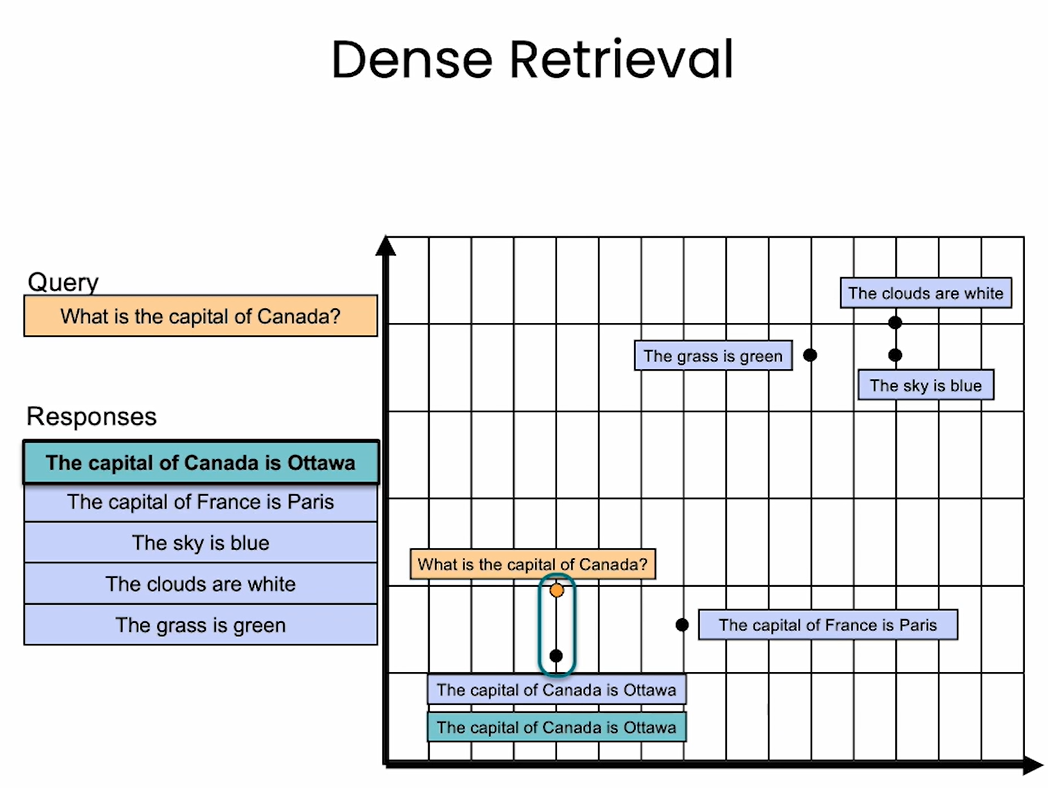

如图所示，我们查询：“加拿大的首都是什么？” 假设此时我们有五个可能的回答或句子。我们可以像在 embeddings 那一节中那样绘制它们。可以看到在图中，意义相似的句子会彼此靠近。因此，如果我们绘制这五个句子，我们会看到有关加拿大和法国首都的句子彼此靠近，而有关颜色的句子聚在右上方。

如果我们使用一个为搜索进行优化的 embeddings 模型将 query 投影到相同的空间中，query 将最接近他所查询的答案。当我们询问“加拿大的首都是什么”时，它将最接近“加拿大的首都是渥太华”这个句子。

以上就是如何将 embeddings 中学到的相似性和距离的特性应用于搜索。

In [15]:
def dense_retrieval(query, 
                    results_lang='en', 
                    properties = ["text", "title", "url", "views", "lang", "_additional {distance}"],
                    num_results=5):
    """
    执行基于给定查询的稠密检索。

    参数：
    - query (str): 用作判断距离和相似性标准的查询。
    - results_lang (str): 过滤结果的语言（默认为英语，'en'）。
    - properties (list): 每个结果要检索的属性列表（默认包括"text"、"title"、"url"、"views"、"lang"和"_additional {distance}"）。
    - num_results (int): 要检索的结果数量。

    返回：
    - result (list): 基于稠密检索的检索到的文章列表。
    """
    nearText = {"concepts": [query]} #这里使用 query 作为评判距离和相似性的标准
    
    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }
    response = (
        client.query
        .get("Articles", properties)
        .with_near_text(nearText)
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
    )

    result = response['data']['Get']['Articles']

    return result

In [17]:
from utils import print_result #这个函数对结果进行排版，使展示出来的结果更易读

### 2.1 基础难度的查询

在此对输出结果中的部分内容进行解释：_additional:{'distance': -150.74162} 结果中的 distance 代表 query 和 result 之间的距离。

In [18]:
query = "谁写了哈姆雷特？"
dense_retrieval_results = dense_retrieval(query,results_lang='zh')
print_result(dense_retrieval_results)

item 0
_additional:{'distance': -150.74162}

lang:zh

text:《哈姆雷特》（）又名《王子復仇记》，是莎士比亞于1599年至1602年间的一部悲劇作品，是他最負盛名和被人引用最多的劇本。習慣上將本劇與《馬克白》、《李爾王》和《奧賽羅》一起，並稱為莎士比亞的“四大悲劇”。

title:哈姆雷特

url:https://zh.wikipedia.org/wiki?curid=72611

views:1000


item 1
_additional:{'distance': -150.65308}

lang:zh

text:威廉·霍尔特·耶茨（William Holt Yates）在1843年写道穆罕默德·阿里帕夏治下的总督阿卜杜拉·拉赫曼·贝伊（Abd-ur-Rahman Bey），据说特别残暴和贪婪。他是一个变节的科普特人，滥用职权敛财。人们甚至认为他曾将人锯成了两半。耶茨还增加了一些细节：“传闻这个家伙后来被暗杀了，是政府批准的。”

title:锯刑

url:https://zh.wikipedia.org/wiki?curid=7157095

views:100


item 2
_additional:{'distance': -149.99219}

lang:zh

text:《哈姆雷特》反映了法国文艺复兴时期人文主义者蒙泰涅的怀疑主义思想。在此之前，人文主义者米蘭多拉認為人是上帝最伟大的造物，具有上帝的形象，并可以选择自己的本性；然而这种观点在蒙泰涅的《隨筆集》中被反驳。哈姆雷特的“人类是一件多么了不得的杰作”与蒙泰涅的思想相呼应，但学者无法确认莎士比亚直接引用了蒙泰涅的作品，还是俩人一同对时代的气息做出了类似的反应。

title:哈姆雷特

url:https://zh.wikipedia.org/wiki?curid=72611

views:1000


item 3
_additional:{'distance': -149.72849}

lang:zh

text:1598年，弗朗西斯·梅洛斯出版了他的《智慧宝库》，涵盖了从乔叟到当时的英国文学，包括了莎士比亚的十二篇戏剧。然而，《哈姆雷特》不在其中，暗示戏剧在当时还没写完。《哈姆雷特》十分出名，《新天鹅》系列编辑伯纳德·

### 2.2 中等难度的查询功能

下边对第一章和这一章中的方法进行了对比。从运行结果中可以看出两种方式的差异，其中 dense_retrieval 识别的结果更加准确。

In [19]:
query = "山西在哪里？"
dense_retrieval_results = dense_retrieval(query,results_lang='zh')
print_result(dense_retrieval_results)

item 0
_additional:{'distance': -154.62271}

lang:zh

text:山西处于中纬度地区。山西坐落于黃土高原東部，有太行山和呂梁山兩座大山，省內最高峰是五臺山，3058米。境内由东北到西南依次分布着大同盆地、忻州盆地、太原盆地、临汾盆地、运城盆地、长治盆地、晋城盆地，阳泉盆地、寿阳盆地、襄垣盆地、黎城盆地等盆地。接邻省区：河北、陕西、河南、内蒙古。

title:山西省

url:https://zh.wikipedia.org/wiki?curid=445

views:1000


item 1
_additional:{'distance': -152.94821}

lang:zh

text:山西疆域轮廓呈东北斜向西南的平行四边形，是典型的为黄土广泛覆盖的山地高原，地势东北高西南低。高原内部起伏不平，河谷纵横，地貌类型复杂多样，有山地、丘陵、台地、平原，山多川少，山地、丘陵面积占全省总面积的80.1%，平川、河谷面积占总面积的19.9%。全省大部分地区海拔在1500米以上，最高点为五台山主峰叶斗峰，海拔3061.1米，为华北最高峰。

title:山西省

url:https://zh.wikipedia.org/wiki?curid=445

views:1000


item 2
_additional:{'distance': -152.31085}

lang:zh

text:山西大学（，縮寫：），簡稱山大，创建于1902年5月8日，前身为山西大学堂，坐落于中华人民共和国山西省太原市小店区，是一所公立高等院校。現為山西省人民政府和教育部共同建設的部省合建大学、第二轮“双一流”建设高校、国家中西部高校综合实力提升工程（一省一校工程）重点建设的14所院校之一，同时还是中西部高校联盟成员。

title:山西大学

url:https://zh.wikipedia.org/wiki?curid=51821

views:100


item 3
_additional:{'distance': -152.27774}

lang:zh

text:山西省，简称晋，中華人民共和國的一個省份，地处黄土高原东翼。山西表里山河，南临黄河，西邻吕梁山，东靠太行山。因在太行山以西，故称山西。省会太原市。省境內春秋時為

In [45]:
from utils import keyword_search

query = "山西在哪里？"
keyword_search_results = keyword_search(query, client,results_lang='zh')
print_result(keyword_search_results)

In [21]:
print(keyword_search_results)

[]


### 2.3 更复杂的查询功能

我们问一些更难回答的问题，看看两种检索算法的差异。

In [22]:
from utils import keyword_search

query = "历史上最高的人是谁？"
keyword_search_results = keyword_search(query, client,results_lang='zh')
print_result(keyword_search_results)

In [23]:
query = "历史上最高的人是谁？"
dense_retrieval_results = dense_retrieval(query,results_lang='zh')
print_result(dense_retrieval_results)

item 0
_additional:{'distance': -151.34534}

lang:zh

text:鲍喜顺在2005年、2008年两度獲得吉尼斯世界纪录認證被承認是地球上因自然原因而長得最高的活人（其他擁有世界之最頭銜的長人不是已逝，如罗伯特·瓦德罗，就是因特殊病變而过度发育稱為巨人症，如列昂尼德·斯塔德尼克）。实际上，这一纪录在2007年即被乌克兰人列昂尼德·斯塔德尼克（Leonid Stadnyk）取代，但因其后来拒绝接受吉尼斯世界纪录组织测量身高而并未被该组织继续认可，故鲍喜顺重新成为世界最高人，直至2009年该纪录持有者被土耳其人蘇丹·科塞（Sultan Kösen）取代。

title:鮑喜順

url:https://zh.wikipedia.org/wiki?curid=180624

views:100


item 1
_additional:{'distance': -151.30365}

lang:zh

text:蘇丹·科塞（；），出生於土耳其马尔丁，是自2009年起被確認為全世界最高的人，被列入金氏世界紀錄大全，其雙手和腳掌亦打破金氏世界紀錄大全，腳掌長達40公分。2009年時，科塞高247公分，到了2012年，他高了4公分，達到251公分。

title:蘇丹·科塞

url:https://zh.wikipedia.org/wiki?curid=2840966

views:200


item 2
_additional:{'distance': -149.78233}

lang:zh

text:瑪麗蓮·沃斯·莎凡特（Marilyn vos Savant，）曾經被記載為吉尼斯世界記錄所認定擁有最高智商的人類及女性 (1984 to 1989)。她於1946年出生於美國密苏里州的圣路易斯，瑪麗蓮在剛滿10歲的1956年9月時初次接受史丹福-比奈智力測驗 （心智年齡比例智商），測得智商高達228，並登上世界紀錄。然而，智商的判定與比較方式後來遭到爭議， 隨後吉尼斯世界記錄在1990年移除了“智商最高的人”這個項目。

title:瑪麗蓮·沃斯·莎凡特

url:https://zh.wikipedia.org/wiki?curid=792357

views:100


item 3
_additional:{'d

接下来，我们使用不同语言询问相同的问题，均用英文来回答。

理论上不同语言被 embeddings 映射后应该在临近的空间内，识别结果应该是相似的。

我们来看一下 dense_retrieval 能否实现这样的效果。 

In [24]:
query = "历史上最高的人是谁？"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

item 0
_additional:{'distance': -150.44846}

lang:en

text:Robert Pershing Wadlow (February 22, 1918 July 15, 1940), also known as the Alton Giant and the Giant of Illinois, was a man who was the tallest person in recorded history for whom there is irrefutable evidence. He was born and raised in Alton, Illinois, a small city near St. Louis, Missouri.

title:Robert Wadlow

url:https://en.wikipedia.org/wiki?curid=359117

views:3000


item 1
_additional:{'distance': -147.66777}

lang:en

text:Manute Bol (; October 16, 1962 – June 19, 2010) was a Sudanese-American professional basketball player and political activist. Listed at or tall, Bol was tied with Gheorghe Mureșan as the tallest player in the history of the National Basketball Association (NBA).

title:Manute Bol

url:https://en.wikipedia.org/wiki?curid=283871

views:2000


item 2
_additional:{'distance': -147.18149}

lang:en

text:Sultan Kösen (born 10 December 1982) is a Turkish farmer who holds the Guinness World Record for talle

In [25]:
query = "أطول رجل في التاريخ" #历史上最高的人是谁？
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

item 0
_additional:{'distance': -147.44199}

lang:en

text:Robert Pershing Wadlow (February 22, 1918 July 15, 1940), also known as the Alton Giant and the Giant of Illinois, was a man who was the tallest person in recorded history for whom there is irrefutable evidence. He was born and raised in Alton, Illinois, a small city near St. Louis, Missouri.

title:Robert Wadlow

url:https://en.wikipedia.org/wiki?curid=359117

views:3000


item 1
_additional:{'distance': -147.09518}

lang:en

text:Kösen turned 40 years old on 10 December 2022. He celebrated his birthday a few days early by visiting the Ripley's Believe It or Not! museum in Orlando, Florida, USA and posing next to a life-sized statue of Robert Wadlow, the tallest man ever at 272 cm (8 ft 11.1 in).

title:Sultan Kösen

url:https://en.wikipedia.org/wiki?curid=8445237

views:2000


item 2
_additional:{'distance': -146.9144}

lang:en

text:Bol and Gheorghe Mureșan are the two tallest players in the history of the National Basketbal

## 三、从头构建语义向量库

### 3.1 文本预处理

In [28]:
from annoy import AnnoyIndex
import numpy as np
import pandas as pd
# import re

/var/folders/tv/9trc210j01l84dk225jl9snh0000gn/T/ipykernel_28307/3442189137.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [29]:
text = """

大革命时期(1919年—1927年).1919年爆发的五四运动成为新民主主义革命的开端,并直接促成1921年7月23日中国共产党第一次全国代表大会召开,宣告中国共产党的成立.此后,中国共产党不断发起工人暴动,反抗北洋政府统治.1924年国民党“一大”后,国民党与共产党实现第一次合作,促成1926年开始的北伐战争的胜利进行.1927年,国民党右派接连发动“四一二”反革命政变和“七一五”反革命政变,第一次国共合作破裂,国民大革命宣告失败.

土地革命战争时期(1927年—1937年).1927年8月1日,中国共产党领导南昌起义,开始武装反抗国民党的反动统治.1927年9月秋收起义后,确定了“农村包围城市,武装夺取政权”的革命道路,开辟了以井冈山为代表的无数农村革命根据地,并成功粉碎国民党的四次“围剿”.1933年—1934年,由于王明"左倾"错误路线影响,第五次反围剿失败.1934年10月开始中国工农红军被迫进行长征.1936年10月三大主力会师甘肃会宁,标志着长征的胜利结束.其间,日本侵占中国东北并不断向南推进.中共主张停止内战,一致抗日；而国民党采取“攘外必先安内”的不抵抗政策,导致国土沦丧.1936年西安事变和平解决后,国共第二次合作初步形成.

抗日战争时期(1931年—1945年).以1931年“九一八”事变为起点,中国人民进入了艰苦卓绝的14年抗战时期.以国共第二次合作为标志,抗日民族统一战线形成,全国人民团结一心,最终打败了日本侵略者,维护了国家的主权独立,极大地提高了国际地位.中国在此后成为联合国安理会五大常任理事国之一.

解放战争时期(1945年—1949年).1945年抗战胜利后,国共进行重庆谈判,签订关于和平建国问题的协定(即《双十协定》).1946年,蒋介石撕毁《双十协定》,发动内战.在中共的英明领导和人民群众的大力支持下,解放战争最终获得胜利.1949年10月1日,中华人民共和国中央人民政府成立,标志着新民主主义革命的基本结束和社会主义革命的开始.

"""

In [43]:
print(text)



大革命时期(1919年—1927年).1919年爆发的五四运动成为新民主主义革命的开端,并直接促成1921年7月23日中国共产党第一次全国代表大会召开,宣告中国共产党的成立.此后,中国共产党不断发起工人暴动,反抗北洋政府统治.1924年国民党“一大”后,国民党与共产党实现第一次合作,促成1926年开始的北伐战争的胜利进行.1927年,国民党右派接连发动“四一二”反革命政变和“七一五”反革命政变,第一次国共合作破裂,国民大革命宣告失败.

土地革命战争时期(1927年—1937年).1927年8月1日,中国共产党领导南昌起义,开始武装反抗国民党的反动统治.1927年9月秋收起义后,确定了“农村包围城市,武装夺取政权”的革命道路,开辟了以井冈山为代表的无数农村革命根据地,并成功粉碎国民党的四次“围剿”.1933年—1934年,由于王明"左倾"错误路线影响,第五次反围剿失败.1934年10月开始中国工农红军被迫进行长征.1936年10月三大主力会师甘肃会宁,标志着长征的胜利结束.其间,日本侵占中国东北并不断向南推进.中共主张停止内战,一致抗日；而国民党采取“攘外必先安内”的不抵抗政策,导致国土沦丧.1936年西安事变和平解决后,国共第二次合作初步形成.

抗日战争时期(1931年—1945年).以1931年“九一八”事变为起点,中国人民进入了艰苦卓绝的14年抗战时期.以国共第二次合作为标志,抗日民族统一战线形成,全国人民团结一心,最终打败了日本侵略者,维护了国家的主权独立,极大地提高了国际地位.中国在此后成为联合国安理会五大常任理事国之一.

解放战争时期(1945年—1949年).1945年抗战胜利后,国共进行重庆谈判,签订关于和平建国问题的协定(即《双十协定》).1946年,蒋介石撕毁《双十协定》,发动内战.在中共的英明领导和人民群众的大力支持下,解放战争最终获得胜利.1949年10月1日,中华人民共和国中央人民政府成立,标志着新民主主义革命的基本结束和社会主义革命的开始.




### 3.2 切块 chunking
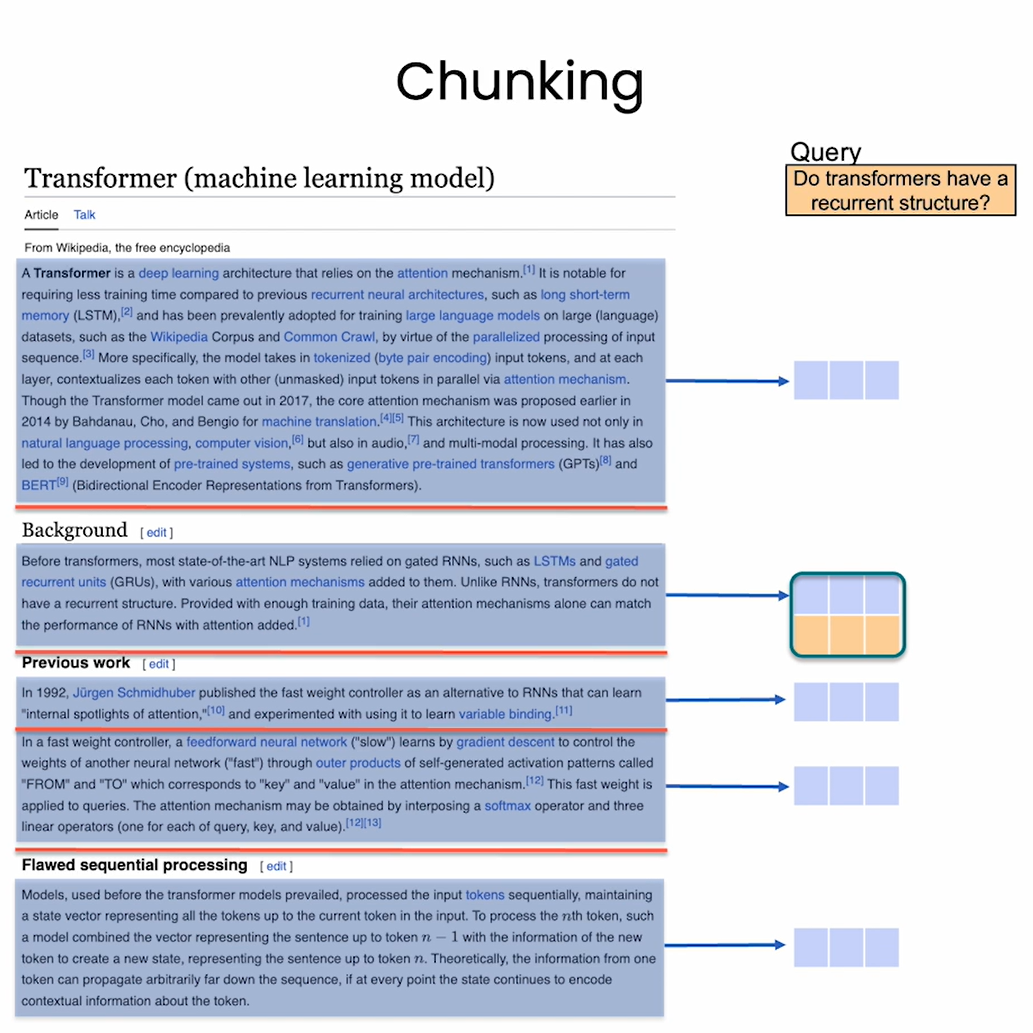

如图所示，切块后将 query 以及搜索内容都映射到 embeddings 空间，对比 query 和搜索内容的相似性以及距离，将会寻找到最符合的答案。

首先我们按标点符号对 text 进行拆分。

In [42]:
# 对句子进行拆分
texts = text.split('.')

# 清除回车和分行
texts = np.array([t.strip(' \n') for t in texts])

print(texts)

['大革命时期(1919年—1927年)'
 '1919年爆发的五四运动成为新民主主义革命的开端,并直接促成1921年7月23日中国共产党第一次全国代表大会召开,宣告中国共产党的成立'
 '此后,中国共产党不断发起工人暴动,反抗北洋政府统治'
 '1924年国民党“一大”后,国民党与共产党实现第一次合作,促成1926年开始的北伐战争的胜利进行'
 '1927年,国民党右派接连发动“四一二”反革命政变和“七一五”反革命政变,第一次国共合作破裂,国民大革命宣告失败'
 '土地革命战争时期(1927年—1937年)' '1927年8月1日,中国共产党领导南昌起义,开始武装反抗国民党的反动统治'
 '1927年9月秋收起义后,确定了“农村包围城市,武装夺取政权”的革命道路,开辟了以井冈山为代表的无数农村革命根据地,并成功粉碎国民党的四次“围剿”'
 '1933年—1934年,由于王明"左倾"错误路线影响,第五次反围剿失败' '1934年10月开始中国工农红军被迫进行长征'
 '1936年10月三大主力会师甘肃会宁,标志着长征的胜利结束' '其间,日本侵占中国东北并不断向南推进'
 '中共主张停止内战,一致抗日；而国民党采取“攘外必先安内”的不抵抗政策,导致国土沦丧' '1936年西安事变和平解决后,国共第二次合作初步形成'
 '抗日战争时期(1931年—1945年)' '以1931年“九一八”事变为起点,中国人民进入了艰苦卓绝的14年抗战时期'
 '以国共第二次合作为标志,抗日民族统一战线形成,全国人民团结一心,最终打败了日本侵略者,维护了国家的主权独立,极大地提高了国际地位'
 '中国在此后成为联合国安理会五大常任理事国之一' '解放战争时期(1945年—1949年)'
 '1945年抗战胜利后,国共进行重庆谈判,签订关于和平建国问题的协定(即《双十协定》)' '1946年,蒋介石撕毁《双十协定》,发动内战'
 '在中共的英明领导和人民群众的大力支持下,解放战争最终获得胜利'
 '1949年10月1日,中华人民共和国中央人民政府成立,标志着新民主主义革命的基本结束和社会主义革命的开始' '']


In [31]:
# 对段落进行拆分
texts = text.split('\n\n')

# 删除空格和新行
texts = np.array([t.strip(' \n') for t in texts])

In [32]:
print(texts)

[''
 '大革命时期(1919年—1927年).1919年爆发的五四运动成为新民主主义革命的开端,并直接促成1921年7月23日中国共产党第一次全国代表大会召开,宣告中国共产党的成立.此后,中国共产党不断发起工人暴动,反抗北洋政府统治.1924年国民党“一大”后,国民党与共产党实现第一次合作,促成1926年开始的北伐战争的胜利进行.1927年,国民党右派接连发动“四一二”反革命政变和“七一五”反革命政变,第一次国共合作破裂,国民大革命宣告失败.'
 '土地革命战争时期(1927年—1937年).1927年8月1日,中国共产党领导南昌起义,开始武装反抗国民党的反动统治.1927年9月秋收起义后,确定了“农村包围城市,武装夺取政权”的革命道路,开辟了以井冈山为代表的无数农村革命根据地,并成功粉碎国民党的四次“围剿”.1933年—1934年,由于王明"左倾"错误路线影响,第五次反围剿失败.1934年10月开始中国工农红军被迫进行长征.1936年10月三大主力会师甘肃会宁,标志着长征的胜利结束.其间,日本侵占中国东北并不断向南推进.中共主张停止内战,一致抗日；而国民党采取“攘外必先安内”的不抵抗政策,导致国土沦丧.1936年西安事变和平解决后,国共第二次合作初步形成.'
 '抗日战争时期(1931年—1945年).以1931年“九一八”事变为起点,中国人民进入了艰苦卓绝的14年抗战时期.以国共第二次合作为标志,抗日民族统一战线形成,全国人民团结一心,最终打败了日本侵略者,维护了国家的主权独立,极大地提高了国际地位.中国在此后成为联合国安理会五大常任理事国之一.'
 '解放战争时期(1945年—1949年).1945年抗战胜利后,国共进行重庆谈判,签订关于和平建国问题的协定(即《双十协定》).1946年,蒋介石撕毁《双十协定》,发动内战.在中共的英明领导和人民群众的大力支持下,解放战争最终获得胜利.1949年10月1日,中华人民共和国中央人民政府成立,标志着新民主主义革命的基本结束和社会主义革命的开始.'
 '']


In [33]:
# 对句子进行拆分
texts = text.split('.')

# 清楚空格和分行
texts = np.array([t.strip(' \n') for t in texts])

为了增加每个分句对模型的可读性，我们为每个句子前添加整段文字的主题内容

In [34]:
title = '新民主主义革命4个发展阶段'

texts = np.array([f"{title} {t}" for t in texts]) 

In [35]:
print(texts)

['新民主主义革命4个发展阶段 大革命时期(1919年—1927年)'
 '新民主主义革命4个发展阶段 1919年爆发的五四运动成为新民主主义革命的开端,并直接促成1921年7月23日中国共产党第一次全国代表大会召开,宣告中国共产党的成立'
 '新民主主义革命4个发展阶段 此后,中国共产党不断发起工人暴动,反抗北洋政府统治'
 '新民主主义革命4个发展阶段 1924年国民党“一大”后,国民党与共产党实现第一次合作,促成1926年开始的北伐战争的胜利进行'
 '新民主主义革命4个发展阶段 1927年,国民党右派接连发动“四一二”反革命政变和“七一五”反革命政变,第一次国共合作破裂,国民大革命宣告失败'
 '新民主主义革命4个发展阶段 土地革命战争时期(1927年—1937年)'
 '新民主主义革命4个发展阶段 1927年8月1日,中国共产党领导南昌起义,开始武装反抗国民党的反动统治'
 '新民主主义革命4个发展阶段 1927年9月秋收起义后,确定了“农村包围城市,武装夺取政权”的革命道路,开辟了以井冈山为代表的无数农村革命根据地,并成功粉碎国民党的四次“围剿”'
 '新民主主义革命4个发展阶段 1933年—1934年,由于王明"左倾"错误路线影响,第五次反围剿失败'
 '新民主主义革命4个发展阶段 1934年10月开始中国工农红军被迫进行长征'
 '新民主主义革命4个发展阶段 1936年10月三大主力会师甘肃会宁,标志着长征的胜利结束'
 '新民主主义革命4个发展阶段 其间,日本侵占中国东北并不断向南推进'
 '新民主主义革命4个发展阶段 中共主张停止内战,一致抗日；而国民党采取“攘外必先安内”的不抵抗政策,导致国土沦丧'
 '新民主主义革命4个发展阶段 1936年西安事变和平解决后,国共第二次合作初步形成'
 '新民主主义革命4个发展阶段 抗日战争时期(1931年—1945年)'
 '新民主主义革命4个发展阶段 以1931年“九一八”事变为起点,中国人民进入了艰苦卓绝的14年抗战时期'
 '新民主主义革命4个发展阶段 以国共第二次合作为标志,抗日民族统一战线形成,全国人民团结一心,最终打败了日本侵略者,维护了国家的主权独立,极大地提高了国际地位'
 '新民主主义革命4个发展阶段 中国在此后成为联合国安理会五大常任理事国之一'
 '新民主主义革命4个发展阶段 解放战争

### 3.2 生成 embeddings

我们将处理后的 texts 传入 cohere 的 embed 函数中生成 embeddings

In [37]:
response = co.embed(
    texts=texts.tolist()    
).embeddings #用 text 生成 embeddings

我们查看一下生成的 embeds 的形状，可以看到不同长度的句子都被映射成相同维度的 embeddings

In [38]:
embeds = np.array(response)
print(embeds.shape) 

(24, 4096)


### 3.3 创建搜索索引

在这一小节中我们会用到 Annoy 库构建索引。这里对 Annoy 做一个简单的科普：
* Annoy 算法的目标是建立一个数据结构能够在较短的时间内找到任何查询点的最近点，在精度允许的条件下通过牺牲准确率来换取比暴力搜索要快的多的搜索速度。
* Annoy 的目标是建立一个数据结构，使得查询一个点的最近邻点的时间复杂度是次线性。
* Annoy 通过建立一个二叉树来使得每个点查找时间复杂度是 O(log n)。

In [39]:
search_index = AnnoyIndex(embeds.shape[1], 'angular')# 这里我们使用 Annoy 算法构建与 embeds 相同个数的索引。

# 将所有的向量添加到搜索索引中
for i in range(len(embeds)):
    search_index.add_item(i, embeds[i])

search_index.build(10) # 10 trees
search_index.save('test.ann')

True

构建 search 函数的主要操作为：
1. 把 query 映射到 embeddings 空间
2. 采用最近邻算法搜寻 search_index 中与 query 距离最相近的向量
3. 生成结果

In [40]:
pd.set_option('display.max_colwidth', None)

def search(query):

  # 先把 query 映射到 embeddings 空间
  query_embed = co.embed(texts=[query]).embeddings

  # 找到映射空间内与 query_embed 最邻近的 text
  similar_item_ids = search_index.get_nns_by_vector(query_embed[0],
                                                    3,
                                                  include_distances=True)
  # 生成结果
  results = pd.DataFrame(data={'texts': texts[similar_item_ids[0]],
                              'distance': similar_item_ids[1]})

  print(texts[similar_item_ids[0]])
    
  return results

In [41]:
query = "大革命时期是哪几年？"
search(query)

['新民主主义革命4个发展阶段 大革命时期(1919年—1927年)' '新民主主义革命4个发展阶段 抗日战争时期(1931年—1945年)'
 '新民主主义革命4个发展阶段 ']


,texts,distance
0,新民主主义革命4个发展阶段 大革命时期(1919年—1927年),0.832203
1,新民主主义革命4个发展阶段 抗日战争时期(1931年—1945年),0.839171
2,新民主主义革命4个发展阶段,0.857479
